# Self-Driving Car Engineer Nanodegree

## Deep Learning

## Project: Build a Traffic Sign Recognition Classifier

In this notebook, a template is provided for you to implement your functionality in stages which is required to successfully complete this project. If additional code is required that cannot be included in the notebook, be sure that the Python code is successfully imported and included in your submission, if necessary. Sections that begin with **'Implementation'** in the header indicate where you should begin your implementation for your project. Note that some sections of implementation are optional, and will be marked with **'Optional'** in the header.

In addition to implementing code, there will be questions that you must answer which relate to the project and your implementation. Each section where you will answer a question is preceded by a **'Question'** header. Carefully read each question and provide thorough answers in the following text boxes that begin with **'Answer:'**. Your project submission will be evaluated based on your answers to each of the questions and the implementation you provide.

>**Note:** Code and Markdown cells can be executed using the **Shift + Enter** keyboard shortcut. In addition, Markdown cells can be edited by typically double-clicking the cell to enter edit mode.

---

## Step 1: Dataset Exploration

Visualize the German Traffic Signs Dataset. This is open ended, some suggestions include: plotting traffic signs images, plotting the count of each sign, etc. Be creative!


The pickled data is a dictionary with 4 key/value pairs:

- features -> the images pixel values, (width, height, channels)
- labels -> the label of the traffic sign
- sizes -> the original width and height of the image, (width, height)
- coords -> coordinates of a bounding box around the sign in the image, (x1, y1, x2, y2). Based the original image (not the resized version).

In [6]:
# Load pickled data
import pickle

# TODO: fill this in based on where you saved the training and testing data
training_file = 'traffic_sign_data/train.p'
testing_file = 'traffic_sign_data/test.p'

with open(training_file, mode='rb') as f:
    train = pickle.load(f)
with open(testing_file, mode='rb') as f:
    test = pickle.load(f)
    
X_train, y_train = train['features'], train['labels']
X_test, y_test = test['features'], test['labels']

In [7]:
### To start off let's do a basic data summary.

import numpy as np

# TODO: number of training examples
n_train = len(X_train)  # 39209

# TODO: number of testing examples
n_test = len(X_test)  # 12630

# TODO: what's the shape of an image?
image_shape = X_test.shape[1:]   # (32,32,3)

# TODO: how many classes are in the dataset
n_classes = np.max(y_test) - np.min(y_test) + 1     # 43

print("Number of training examples =", n_train)
print("Number of testing examples =", n_test)
print("Image data shape =", image_shape)
print("Number of classes =", n_classes)

Number of training examples = 39209
Number of testing examples = 12630
Image data shape = (32, 32, 3)
Number of classes = 43


In [8]:
### Data exploration visualization goes here.
### Feel free to use as many code cells as needed.

### Plotting images

A helper function will plot 42 traffic signs in 6 rows and 7 columns. It displays the true class and the predicted class if given.


In [9]:
%matplotlib inline
import matplotlib.pyplot as plt

def plot_images(images, cls_true, cls_pred=None):
    assert len(images) == len(cls_true) == 42

    # Create figure with 6x7 sub-plots.
    fig, axes = plt.subplots(6, 7, figsize=(9,10))
    fig.subplots_adjust(hspace=0.2, wspace=0.2)

    for i, ax in enumerate(axes.flat):
        # Plot image.
        ax.imshow(images[i].reshape(image_shape))

        # Show true and predicted classes.
        if cls_pred is None:
            xlabel = "cl: {0}".format(cls_true[i])
        else:
            xlabel = "cl: {0}, pr: {1}".format(cls_true[i], cls_pred[i])

        ax.set_xlabel(xlabel)

        # Remove ticks from the plot.
        ax.set_xticks([])
        ax.set_yticks([])


The images have 32\*32 pixel dimension, 3 colors and a large spread of quality.  Some of them are very hard to be identified even for humans.  There are many dark images so I've selected a lighter representative of each class (mean pixel value > 130)

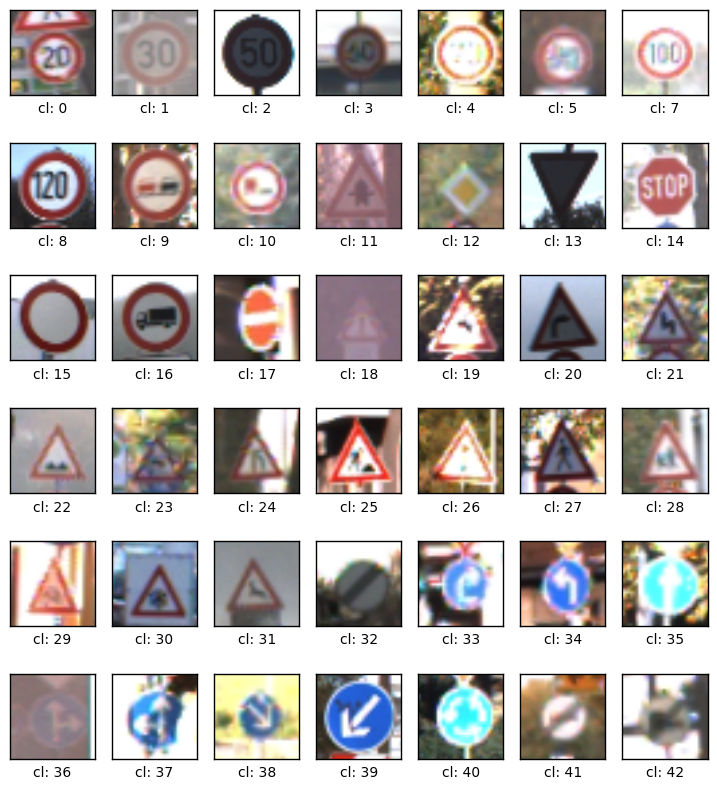

In [10]:
images = []
imgcls = []

for i in range(n_train):
    if np.mean(X_train[i]) > 130 and y_train[i] not in imgcls:
        images.append(X_train[i])
        imgcls.append(y_train[i])


plot_images(images, imgcls)

There are 43 classes in total.  Class 6 is missing from the above enumeration because all samples are very dark.

Let's have a look on the dark side of the class 6, maybe we can catch a lighter sample.

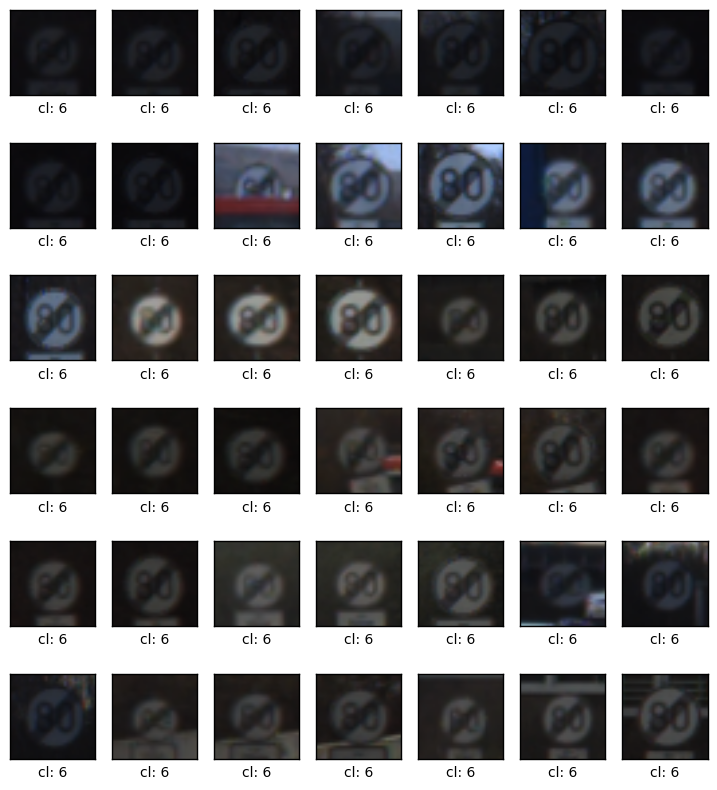

In [11]:
images = []
imgcls = []

for i in range(n_train):
    if y_train[i] == 6:
        images.append(X_train[i])
        imgcls.append(y_train[i])


plot_images(images[:420:10], imgcls[:420:10])


These images are really very dark.  Let's try to normalize the images and to transform the pixels of 0..255 integers to 0..1 float range.

### Normalize

In [12]:
def normalize(image_data):
    """
    Normalize the image data with Min-Max scaling to a range of [0.01, 0.99]
    :param image_data: The image data to be normalized
    :return: Normalized image data
    """
    a = 0.01
    b = 0.99
    norm_img = []
    for img in image_data:
        x_min = np.min(img)
        x_max = np.max(img)
        norm_img.append(a + (img - x_min) * (b - a) / (x_max - x_min))
    return np.array(norm_img)

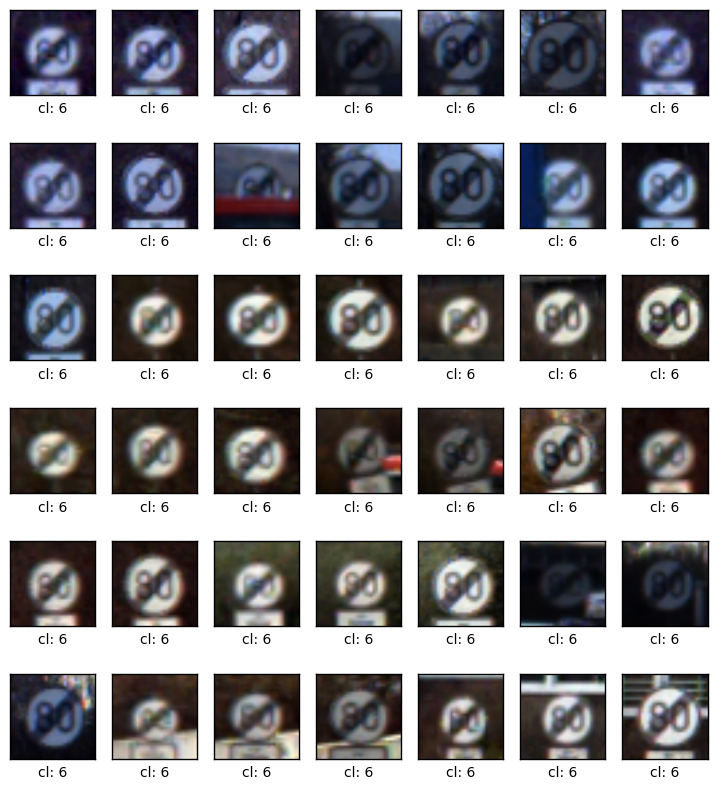

In [13]:
plot_images(normalize(images[:420:10]), imgcls[:420:10])

After normalization almost all traffic signs of the above sample can be identified.

I do hope if humans can distinguish more clearly these traffic signs then this will help the classification by the computer as well.

Let's normalize all training and testing features.

In [14]:
train_features = normalize(X_train)
test_features = normalize(X_test)
# Change to float32, we're working with float32 in tf
train_features = train_features.astype(np.float32)
test_features = test_features.astype(np.float32)

print('Features normalized on 0.01 - 0.99 scale')

Features normalized on 0.01 - 0.99 scale


### One-Hot-Encoding

Let's apply one-hot-encoding on training and test labels.

In [15]:
# Turn labels into numbers and apply One-Hot Encoding
from sklearn.preprocessing import LabelBinarizer

encoder = LabelBinarizer()
encoder.fit(y_train)
train_labels = encoder.transform(y_train)
test_labels = encoder.transform(y_test)

# Change to float32, so it can be multiplied against 
# the features in TensorFlow, which are float32
train_labels = train_labels.astype(np.float32)
test_labels = test_labels.astype(np.float32)

print('Labels One-Hot Encoded')

Labels One-Hot Encoded


### Create validation set

In [16]:
# Get randomized datasets for training and validation
from sklearn.model_selection import train_test_split

train_features, valid_features, train_labels, valid_labels = train_test_split(
    train_features,
    train_labels,
    test_size=0.05,
    random_state=42)

print('Training features and labels randomized and split.')

Training features and labels randomized and split.


### Save data

In [ ]:
# Save the data for easy access
import os

pickle_file = 'traf_sign_norm_1hot.pickle'
if not os.path.isfile(pickle_file):
    print('Saving data to pickle file...')
    try:
        with open('traf_sign_norm_1hot.pickle', 'wb') as pfile:
            pickle.dump(
                {
                    'train_dataset': train_features,
                    'train_labels': train_labels,
                    'valid_dataset': valid_features,
                    'valid_labels': valid_labels,
                    'test_dataset': test_features,
                    'test_labels': test_labels,
                },
                pfile, pickle.HIGHEST_PROTOCOL)
    except Exception as e:
        print('Unable to save data to', pickle_file, ':', e)
        raise

print('Data cached in pickle file.')

----

## Step 2: Design and Test a Model Architecture

Design and implement a deep learning model that learns to recognize traffic signs. Train and test your model on the [German Traffic Sign Dataset](http://benchmark.ini.rub.de/?section=gtsrb&subsection=dataset).

There are various aspects to consider when thinking about this problem:

- Your model can be derived from a deep feedforward net or a deep convolutional network.
- Play around preprocessing techniques (normalization, rgb to grayscale, etc)
- Number of examples per label (some have more than others).
- Generate fake data.

Here is an example of a [published baseline model on this problem](http://yann.lecun.com/exdb/publis/pdf/sermanet-ijcnn-11.pdf). It's not required to be familiar with the approach used in the paper but, it's good practice to try to read papers like these.

### Implementation

Use the code cell (or multiple code cells, if necessary) to implement the first step of your project. Once you have completed your implementation and are satisfied with the results, be sure to thoroughly answer the questions that follow.

In [ ]:
### Preprocess the data here.
### Feel free to use as many code cells as needed.

### Loading data

Preprocessing of data has been done in previous steps and it has been saved in a pickle file.  In this step we have the opportunity to load the preprocessed data.

In [1]:
# Load the modules
%matplotlib inline
import matplotlib.pyplot as plt
import pickle

import numpy as np
import tensorflow as tf
from tqdm import tqdm


In [2]:


# Reload the data
pickle_file = 'traf_sign_norm_1hot.pickle'
with open(pickle_file, 'rb') as f:
  pickle_data = pickle.load(f)
  train_features = pickle_data['train_dataset']
  train_labels = pickle_data['train_labels']
  valid_features = pickle_data['valid_dataset']
  valid_labels = pickle_data['valid_labels']
  test_features = pickle_data['test_dataset']
  test_labels = pickle_data['test_labels']
  del pickle_data  # Free up memory


print('Data and modules loaded.')

Data and modules loaded.


### Question 1 

_Describe the techniques used to preprocess the data._

**Answer:**

### Warm-up procedure: Simple linear model

Let's try to classify the data with a simple linear model in the first step, to have a base case and to see what might be expected on later experiments.

The example from CarND-TensorFlow-Lab has been adapted for traffic signs with 32\*32 pixels and RGB colors.

In [3]:

features_count = 32 * 32 * 3   # 3072
labels_count = 43

# Set the features and labels tensors (placeholder)
features = tf.placeholder(tf.float32)
labels = tf.placeholder(tf.float32)

# Set the weights and biases tensors
weights = tf.Variable(tf.truncated_normal([features_count,labels_count]))
biases = tf.Variable(tf.zeros([labels_count]))

# Feed dicts for training, validation, and test session
train_features = np.reshape(train_features, [-1, 3072])
valid_features = np.reshape(valid_features, [-1, 3072])
test_features = np.reshape(test_features, [-1, 3072])
train_feed_dict = {features: train_features, labels: train_labels}
valid_feed_dict = {features: valid_features, labels: valid_labels}
test_feed_dict = {features: test_features, labels: test_labels}

logits = tf.matmul(features, weights) + biases

prediction = tf.nn.softmax(logits)

# Cross entropy
# cross_entropy = -tf.reduce_sum(labels * tf.log(prediction), reduction_indices=1)
# it seems that some logits have 0 which makes tf.log infinite (NaN) - the fix for this:
cross_entropy = tf.nn.softmax_cross_entropy_with_logits(logits=logits, labels=labels)  # [batch]

# Training loss
loss = tf.reduce_mean(cross_entropy)

# Determine if the predictions are correct
is_correct_prediction = tf.equal(tf.argmax(prediction, 1), tf.argmax(labels, 1))

# Calculate the accuracy of the predictions
accuracy = tf.reduce_mean(tf.cast(is_correct_prediction, tf.float32))

print('Accuracy function created.')

Accuracy function created.


Epoch 10/10: 100%|██████████| 372/372 [00:02<00:00, 137.80batches/s]


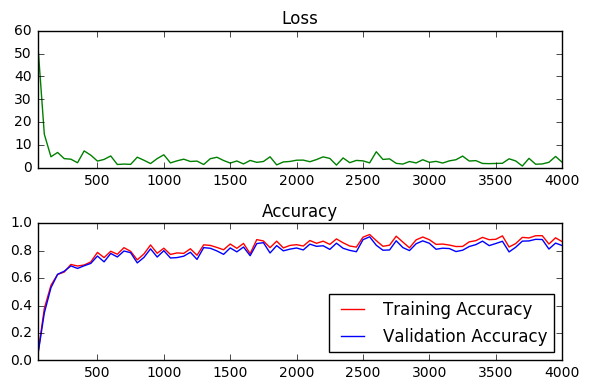

Validation accuracy at 0.8551759123802185
Test accuracy at 0.7773559093475342


In [5]:
epochs = 10
batch_size = 100
learning_rate = 0.05

# Gradient Descent
# optimizer = tf.train.GradientDescentOptimizer(learning_rate).minimize(loss)    
# Adam Optimizer - gives better results
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(loss)

# Create an operation that initializes all variables
# this should follow Adam Optimizer because there are variables inside Adam
init = tf.initialize_all_variables()

# The accuracy measured against the validation set
validation_accuracy = 0.0

# Measurements use for graphing loss and accuracy
log_batch_step = 50
batches = []
loss_batch = []
train_acc_batch = []
valid_acc_batch = []

with tf.Session() as session:
    session.run(init)
#    batch_count = int(math.ceil(len(train_features)/batch_size))
    batch_count = int(len(train_features)/batch_size)

    for epoch_i in range(epochs):
        
        # Progress bar
        batches_pbar = tqdm(range(batch_count), desc='Epoch {:>2}/{}'.format(epoch_i+1, epochs), unit='batches')
        
        # The training cycle
        for batch_i in batches_pbar:
            # Get a batch of training features and labels
            batch_start = batch_i*batch_size
            batch_features = train_features[batch_start:batch_start + batch_size]
            batch_labels = train_labels[batch_start:batch_start + batch_size]

            # Run optimizer and get loss
            _, l = session.run(
                [optimizer, loss],
                feed_dict={features: batch_features, labels: batch_labels})

            # Log every 50 batches
            if not batch_i % log_batch_step:
                # Calculate Training and Validation accuracy
                training_accuracy = session.run(accuracy, feed_dict=train_feed_dict)
                validation_accuracy = session.run(accuracy, feed_dict=valid_feed_dict)

                # Log batches
                previous_batch = batches[-1] if batches else 0
                batches.append(log_batch_step + previous_batch)
                loss_batch.append(l)
                train_acc_batch.append(training_accuracy)
                valid_acc_batch.append(validation_accuracy)

        # Check accuracy against Validation data
        validation_accuracy = session.run(accuracy, feed_dict=valid_feed_dict)
        test_accuracy = session.run(accuracy, feed_dict=test_feed_dict)

loss_plot = plt.subplot(211)
loss_plot.set_title('Loss')
loss_plot.plot(batches, loss_batch, 'g')
loss_plot.set_xlim([batches[0], batches[-1]])
acc_plot = plt.subplot(212)
acc_plot.set_title('Accuracy')
acc_plot.plot(batches, train_acc_batch, 'r', label='Training Accuracy')
acc_plot.plot(batches, valid_acc_batch, 'b', label='Validation Accuracy')
acc_plot.set_ylim([0, 1.0])
acc_plot.set_xlim([batches[0], batches[-1]])
acc_plot.legend(loc='best')
plt.tight_layout()
plt.show()

print('Validation accuracy at {}'.format(validation_accuracy))
print('Test accuracy at {}'.format(test_accuracy))


I think this is about the maximum what we can squeze out of a simple linear logistic model.  The first GradientDescentOptimizer experiments gave accuracy around 0.6 but with AdamOptimizer and some more parameter tuning this could be improved to an accuracy around 0.8

In [ ]:
### Generate data additional (if you want to!)
### and split the data into training/validation/testing sets here.
### Feel free to use as many code cells as needed.

### Question 2

_Describe how you set up the training, validation and testing data for your model. If you generated additional data, why?_

**Answer:**

In [ ]:
### Define your architecture here.
### Feel free to use as many code cells as needed.

### Question 3

_What does your final architecture look like? (Type of model, layers, sizes, connectivity, etc.)  For reference on how to build a deep neural network using TensorFlow, see [Deep Neural Network in TensorFlow
](https://classroom.udacity.com/nanodegrees/nd013/parts/fbf77062-5703-404e-b60c-95b78b2f3f9e/modules/6df7ae49-c61c-4bb2-a23e-6527e69209ec/lessons/b516a270-8600-4f93-a0a3-20dfeabe5da6/concepts/83a3a2a2-a9bd-4b7b-95b0-eb924ab14432) from the classroom._


**Answer:**

In [ ]:
### Train your model here.
### Feel free to use as many code cells as needed.

### Question 4

_How did you train your model? (Type of optimizer, batch size, epochs, hyperparameters, etc.)_


**Answer:**

### Question 5


_What approach did you take in coming up with a solution to this problem?_

**Answer:**

---

## Step 3: Test a Model on New Images

Take several pictures of traffic signs that you find on the web or around you (at least five), and run them through your classifier on your computer to produce example results. The classifier might not recognize some local signs but it could prove interesting nonetheless.

You may find `signnames.csv` useful as it contains mappings from the class id (integer) to the actual sign name.

### Implementation

Use the code cell (or multiple code cells, if necessary) to implement the first step of your project. Once you have completed your implementation and are satisfied with the results, be sure to thoroughly answer the questions that follow.

In [ ]:
### Load the images and plot them here.
### Feel free to use as many code cells as needed.

### Question 6

_Choose five candidate images of traffic signs and provide them in the report. Are there any particular qualities of the image(s) that might make classification difficult? It would be helpful to plot the images in the notebook._



**Answer:**

In [ ]:
### Run the predictions here.
### Feel free to use as many code cells as needed.

### Question 7

_Is your model able to perform equally well on captured pictures or a live camera stream when compared to testing on the dataset?_


**Answer:**

In [ ]:
### Visualize the softmax probabilities here.
### Feel free to use as many code cells as needed.

### Question 8

*Use the model's softmax probabilities to visualize the **certainty** of its predictions, [`tf.nn.top_k`](https://www.tensorflow.org/versions/r0.11/api_docs/python/nn.html#top_k) could prove helpful here. Which predictions is the model certain of? Uncertain? If the model was incorrect in its initial prediction, does the correct prediction appear in the top k? (k should be 5 at most)*


**Answer:**

### Question 9
_If necessary, provide documentation for how an interface was built for your model to load and classify newly-acquired images._


**Answer:**

> **Note**: Once you have completed all of the code implementations and successfully answered each question above, you may finalize your work by exporting the iPython Notebook as an HTML document. You can do this by using the menu above and navigating to  \n",
    "**File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission.